# DSCI 573 - Feature and Model Selection

## Lab 1: Evaluation metrics

_Note that the labs will get more open-ended in this course compared to DSCI 571. I won't be explicitly providing instructions for all the steps you need follow assuming that you have learned good practices for building a supervised machine learning pipeline in DSCI 571. Also, sometimes you will have to make your own choices and your own decisions, for example, on what parameter values to use when they are not explicitly provided in the instructions or what transformations you want to apply on certain columns. Use your own judgment in such cases and justify your choices, if necessary._

## Table of contents

- [Submission guidelines](#sg) (3%)
- [Exercise 0: Remembering important concepts from 571](#0) (12%)
- [Exercise 1: Precision, recall, and f1 score by hand](#1) (15%)
- [Exercise 2: Classification evaluation metrics using `sklearn`](#) (48%)
- [Exercise 3: Regresison metrics](#3) (22%)

In [1]:
import os
import sys
from hashlib import sha1
import altair as alt

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tests_lab1
from sklearn import datasets
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    precision_score,
    recall_score,
    average_precision_score, 
    auc
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC, SVR
from sklearn.model_selection import cross_val_predict

<br><br>

## Submission instructions <a name="si"></a>
<hr>
rubric={mechanics:3}

You will receive marks for correctly submitting this assignment. To submit this assignment, follow the instructions below:

- **Please add a link to your GitHub repository here: [LINK TO MY REPO](https://github.ubc.ca/mds-2021-22/DSCI_573_lab1_azandian)**
- Be sure to follow the [general lab instructions](https://ubc-mds.github.io/resources_pages/general_lab_instructions/).
- Make at least three commits in your lab's GitHub repository.
- Push the final .ipynb file with your solutions to your GitHub repository for this lab.
- Upload the .ipynb file to Gradescope.
- If the .ipynb file is too big and doesn't render on Gradescope, also upload a pdf in addition to the .ipynb. 
- Make sure that your plots/output are rendered properly in Gradescope.

> [Here](https://github.com/UBC-MDS/public/tree/master/rubric) you will find the description of each rubric used in MDS.

> As usual, do not push the data to the repository. 

## Exercise 0: Remembering important concepts from 571 
<hr>

### 0.1 Short answer questions 
rubric={reasoning:12}

Answer the following questions in 1 to 4 sentences. 

1. What is the problem with calling `fit_transform` on your test data for transformers such as `CountVectorizer`?
2. Why is it important to follow the Golden Rule? 
3. What are two advantages of using `sklearn` Pipelines? When is it appropriate to use `sklearn` column transformers? 
4. If you could only access one of `predict` or `predict_proba`, which one would you choose? Briefly explain.
5. What are two advantages of `RandomizedSearchCV` over `GridSearchCV`?
6. Suppose you are training a `LogisticRegression` classifier of `sklearn` on a binary classification problem. How do you know which class is considered "positive" and which one is "negative"?  

_1. We are not only breaking the golden rule here by exposing the our model (the fitting section of our model) to the test data, but also are ignoring the whole train data set when we use the test data to fit our model._  
_2. Using the Golden Rule we will be able to build a model that would generalize well with the deployment data. If our model sees the test data during fit or transformation, the score results we get will become biased and we will not be able to tell how our model will be performing with new data._  
_3. One advantage of pipelines is that we could identify the steps that we need to do for transforming the data and fitting the data in our model in one take. The other advantage is while using functions like cross_validate where we don't want to break the Golden rule by exposing the validation set to the transform and fit. Using pipeline we can do the data transform and fit separately for each fold of the cross validation. Column transformers are used when we want to apply different sets of transformation and models to different columns (e.g. categorical, numerical ...)._  
_4. I would use `predict_proba` because it gives more information with the probability that the model uses (indicating model's confidence level) to define our target. We could derive `predict` from `predict_proba` by applying a threshold to it._  
_5. First, We could define maximum number of iterations that we want over a list of parameter search values. Second, we could define and assign probability distributions to our parameter search grid which will be useful for the cases when our parameters follow a pattern and one is more important than the rest._  
_6. In order to match the prediction score that we are getting from our model with respective classes, we can use `our_model.classes_` to pull out the order of the classes that give that score. The first element on the output array for classes will be the negative class._

<br><br>

### (Optional) 0.2
rubric={reasoning:1}

You have a (fictional) model that trains in $\mathcal{O}(n^2d)$ time (total) and makes predictions in $\mathcal{O}(d^2)$ time (per example), where $n$ is the number of examples and $d$ is the number of features. What is the time complexity of evaluating this model with $k$-fold cross-validation? Answer using big-O notation and explain or show your work. Your answer may depend on $n$, $d$, and/or $k$.

_For each fold of CV we have $O(n^2d)$ time to train and $O(d^2n)$ to predict n examples. This is a total of $O(n^2d + nd^2)$. Doing this k times (number of folds), we get $O(kn^2d + knd^2)$. However, since k is a low order multiplier and we can ignore it which give us $O(n^2d + nd^2)$._

<br><br><br><br>

## Exercise 1: Precision, recall, and f1 score by hand <a name="1"></a>
<hr>

Consider the problem of predicting whether a patient has a disease or not. Below are confusion matrices of two machine learning models: Model A and Model B. 

- Model A

|    Actual/Predicted      | Predicted disease | Predicted no disease |
| :------------- | -----------------------: | -----------------------: |
| **Actual disease**       | 2 | 8 |
| **Actual no disease**       | 0 | 100 |


- Model B

|    Actual/Predicted      | Predicted disease | Predicted no disease |
| :------------- | -----------------------: | -----------------------: |
| **Actual disease**       | 6 | 4 |
| **Actual no disease**       | 10 | 90 |

### 1.1 Positive vs. negative class 
rubric={reasoning:2}

**Your tasks:**

Precision, recall, and f1 score depend upon which class is considered "positive", that is the thing you wish to find. In the example above, conceptually, which class should be considered as the "positive" class? In other words, what are you likely to be interested in spotting?

_Having `disease` should be considered as the positive class because we are interested in predicting if a patient has a disease or not._

<br><br>

### 1.2 Accuracy
rubric={accuracy:2}

**Your tasks:**

What are the accuracies for Model A and Model B? 

We'll store all metrics associated with Model A and Model B in the `results_dict` below. 

> Try storing your answers as fractions (e.g., 1/4) if you are having trouble with `assert` statements. 

In [2]:
results_dict = {"A": {}, "B": {}}

In [3]:
results_dict["A"]["accuracy"] = (100 + 2) / 110
results_dict["B"]["accuracy"] = (90 + 6) / 110



In [4]:
assert tests_lab1.ex1_2_1(
    results_dict["A"]["accuracy"]
), "Your answer is incorrect, see traceback above."
print("Success")

Success


In [5]:
assert tests_lab1.ex1_2_2(
    results_dict["B"]["accuracy"]
), "Your answer is incorrect, see traceback above."
print("Success")

Success


In [6]:
pd.DataFrame(results_dict)

,A,B
accuracy,0.927273,0.872727


<br><br>

### 1.3 Which model would you pick? 
rubric={reasoning:1}

**Your tasks:**

Which model would you pick simply based on the accuracy metric? 

_Model A._

<br><br>

### 1.4 Precision, recall, f1-score
rubric={accuracy:6}

**Your tasks:**

Calculate precision, recall, f1-score for Model A and Model B manually, without using `scikit-learn` tools. 

> Try storing your answers as fractions (e.g., 1/4) if you are having trouble with `assert` statements. 

In [7]:
results_dict["A"]["precision"] = 2 / (2 + 0)
results_dict["B"]["precision"] = 6 / (6 + 10)
results_dict["A"]["recall"] = 2 / (2 + 8)
results_dict["B"]["recall"] = 6 / (6 + 4)
results_dict["A"]["f1"] = (
    2
    * results_dict["A"]["precision"]
    * results_dict["A"]["recall"]
    / (results_dict["A"]["precision"] + results_dict["A"]["recall"])
)
results_dict["B"]["f1"] = (
    2
    * results_dict["B"]["precision"]
    * results_dict["B"]["recall"]
    / (results_dict["B"]["precision"] + results_dict["B"]["recall"])
)

In [8]:
assert tests_lab1.ex1_4_1(
    results_dict["A"]["precision"]
), "Your answer is incorrect, see traceback above."
print("Success")

Success


In [9]:
assert tests_lab1.ex1_4_2(
    results_dict["B"]["precision"]
), "Your answer is incorrect, see traceback above."
print("Success")

Success


In [10]:
assert tests_lab1.ex1_4_3(
    results_dict["A"]["recall"]
), "Your answer is incorrect, see traceback above."
print("Success")

Success


In [11]:
assert tests_lab1.ex1_4_4(
    results_dict["B"]["recall"]
), "Your answer is incorrect, see traceback above."
print("Success")

Success


In [12]:
assert tests_lab1.ex1_4_5(
    results_dict["A"]["f1"]
), "Your answer is incorrect, see traceback above."
print("Success")

Success


In [13]:
assert tests_lab1.ex1_4_6(
    results_dict["B"]["f1"]
), "Your answer is incorrect, see traceback above."
print("Success")

Success


Show the dataframe with all results. 

In [14]:
pd.DataFrame(results_dict)

,A,B
accuracy,0.927273,0.872727
precision,1.000000,0.375000
recall,0.200000,0.600000
f1,0.333333,0.461538


<br><br>

### 1.5 Discussion
rubric={reasoning:4}

**Your tasks:**
1. Which metric is more informative in this problem: precision or recall? Why? 
2. Which model would you pick based on this information?s

_1. Recall is much more important than precision because we are more interested to know what percentage of the people with actual disease we were able to predict correctly (in order to cure on time)._  
_2. Based on the above rationale, I will pick model B over A for higher recall score._

<br><br>

### (Optional) 1.6 
rubric={reasoning:1}

**Your tasks:**

Provide 4 to 5 example classification datasets (with links) where accuracy metric would be misleading. Discuss which evaluation metric would be more appropriate for each dataset. 

<br><br><br><br>

### Exercise 2: Classification evaluation metrics using `sklearn` <a name="2"></a>
<hr>

In general, when a dataset is imbalanced, accuracy does not provide the whole story. In class, we looked at credit card fraud dataset which is a classic example of an imbalanced dataset. 

Another example is customer churn datasets. [Customer churn](https://en.wikipedia.org/wiki/Customer_attrition) refers to the notion of customers leaving a subscription service like Netflix. In this exercise, we will try to predict customer churn in a dataset where most of the customers stay with the service and a small minority cancel their subscription. To start, download the [Kaggle telecom customer churn dataset](https://www.kaggle.com/becksddf/churn-in-telecoms-dataset). 

The starter code below reads the data CSV as a pandas dataframe, assuming that it's stored as `bigml_59c28831336c6604c800002a.csv` in your lab folder, and splits it into 70% train and 30% test. 

The `churn` column in the dataset is the target. "True" means the customer left the subscription (churned) and "False" means they stayed.


> Note that for customer churn problems a more appropriate technique is something called survival analysis, which you'll learn about in DSCI 562. For the purpose of this assignment, we'll just treat this problem as a binary classification problem.   

In [15]:
df = pd.read_csv("bigml_59c28831336c6604c800002a.csv", encoding="utf-8",)
train_df, test_df = train_test_split(df, test_size=0.3, random_state=123)
train_df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
1402,NE,70,415,421-8535,no,no,0,213.4,86,36.28,...,77,17.40,256.6,101,11.55,5.7,4,1.54,1,False
1855,WI,67,510,417-2265,no,no,0,109.1,134,18.55,...,76,12.10,91.2,86,4.10,10.9,5,2.94,2,False
633,NJ,122,415,327-9341,no,yes,34,146.4,104,24.89,...,103,7.62,220.0,91,9.90,15.6,4,4.21,2,False
1483,NV,107,510,419-9688,yes,no,0,234.1,91,39.80,...,105,13.86,282.5,100,12.71,10.0,3,2.70,1,False
2638,HI,105,510,364-8128,no,no,0,125.4,116,21.32,...,95,22.23,241.6,104,10.87,11.4,9,3.08,2,False


In [16]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2333 entries, 1402 to 1346
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   2333 non-null   object 
 1   account length          2333 non-null   int64  
 2   area code               2333 non-null   int64  
 3   phone number            2333 non-null   object 
 4   international plan      2333 non-null   object 
 5   voice mail plan         2333 non-null   object 
 6   number vmail messages   2333 non-null   int64  
 7   total day minutes       2333 non-null   float64
 8   total day calls         2333 non-null   int64  
 9   total day charge        2333 non-null   float64
 10  total eve minutes       2333 non-null   float64
 11  total eve calls         2333 non-null   int64  
 12  total eve charge        2333 non-null   float64
 13  total night minutes     2333 non-null   float64
 14  total night calls       2333 non-null

<br><br>

### 2.1 Distribution of target values
rubric={reasoning:2}

**Your tasks:**

Examine the distribution of target values in the train split. Do you see class imbalance? If yes, do we need to deal with it? Why or why not? 

In [17]:
dist = train_df["churn"].value_counts(normalize=True)
dist

False    0.850407
True     0.149593
Name: churn, dtype: float64

In [18]:
print(f"proportion of True target values is {round(dist[1], 2) * 100}%")

proportion of True target values is 15.0%


_This is a churn problem and class imbalance is expected. Only 15% of the target values are positive (True) which indicates a target class imbalance. Accuracy is misleading when we have class imbalance. We usually need to deal with class imbalance but in the case for this dataset it is not too bad and we could ignore it. We could take a look at our precision and recall scores to see if this imbalance is truly affecting the results, and if so, deal with the imbalance._ 

<br><br>

### (Optional) 2.2 EDA 
rubric={reasoning:1}

**Your tasks:**

Come up with **two** exploratory questions you would like to answer and explore those. Briefly discuss your results in 1-3 sentences.

You are welcome to use `pandas_profiling` but you don't have to.

_Question 1: Is churn lower for customers with longer account length? The bar chart below shows that the distribution of both churn and non-churn targets look normally distributed. I created a normalized stack bar to see if this percentage decreases as the Account length increases. It appears that not! The ratio between these two is almost the same and actually increases towards the end (I have clipped out the outliers from the plot)._

alt.renderers.enable('mimetype')
alt.Chart(train_df).mark_bar().encode(
    x=alt.X("account length", bin=alt.Bin(maxbins=40)),
    y=alt.Y("count()", title="Count of accounts"),
    color="churn"
)

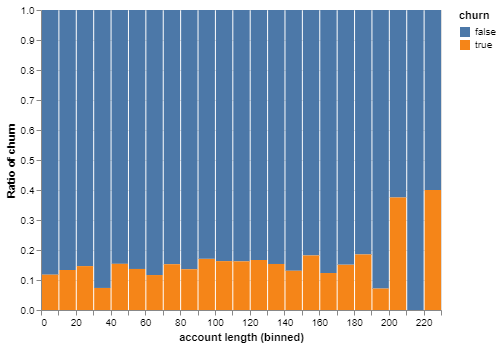

In [19]:
alt.renderers.enable('mimetype')
alt.Chart(train_df).mark_bar(clip=True).encode(
    x=alt.X("account length", bin=alt.Bin(maxbins=40), scale=alt.Scale(domain=(0, 230))),
    y=alt.Y("count()", stack="normalize", title="Ratio of churn"),
    color="churn"
)

_Question 2: Do customers who talk longer on phone in the morning also talk longer at night? Is the talk length pattern different for people of a certain area code?_  
According to the below interactive EDA (you may click on the bar chart categories to select mapping on the binned scatter chart), it is obvious that there is no trend between talk time in the day and at night. Also when looking at each area code we don't see at trend and both feature seem to be following a similar joint distribution.

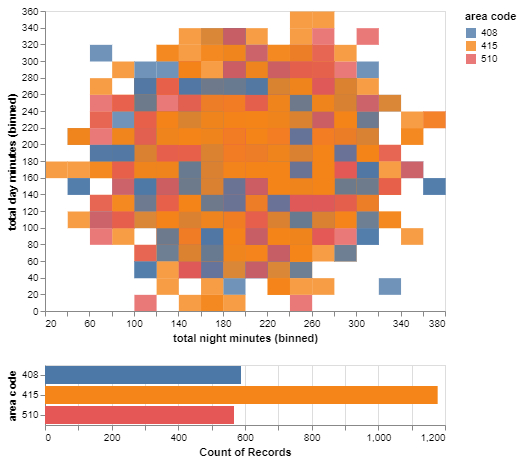

In [20]:
click = alt.selection_multi(fields=["area code"])

scatter = (
    alt.Chart(train_df)
    .mark_rect(opacity=0.8)
    .encode(
        x=alt.X("total night minutes", bin=alt.Bin(maxbins=30)),
        y=alt.Y("total day minutes", bin=alt.Bin(maxbins=30)),
        color=alt.condition(
            click,
            alt.Color("area code:O", scale=alt.Scale(scheme="tableau10")),
            alt.value("lightgrey"),
        ),
    )
)

bar = scatter.mark_bar().encode(
    x="count()",
    y="area code:O",
    opacity=alt.condition(click, alt.value(1), alt.value(0.2)),
)

(scatter & bar).add_selection(click)

<br><br>

### 2.3 Feature transformations 
rubric={accuracy:4,reasoning:2}

Run the code below which creates `X_train`, `y_train`, `X_test`, `y_test`. 

**Your tasks:**

In preparation for building a classifier, set up a `ColumnTransformer` that performs whatever feature transformations you deem sensible. This can include dropping features if you think they are not helpful. Remember that by default `ColumnTransformer` will drop any columns that aren't accounted for when it's created.

In each case, briefly explain your rationale with 1-2 sentences. You do not need an explanation for every feature, but for every group of features that are being transformed the same way. For example, "I am doing transformation X to the following categorical features: `a`, `b`, `c` because of reason Y," etc.

In [21]:
X_train = train_df.drop(columns=["churn"])
X_test = test_df.drop(columns=["churn"])

y_train = train_df["churn"]
y_test = test_df["churn"]

In [22]:
X_train.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls
1402,NE,70,415,421-8535,no,no,0,213.4,86,36.28,204.7,77,17.40,256.6,101,11.55,5.7,4,1.54,1
1855,WI,67,510,417-2265,no,no,0,109.1,134,18.55,142.3,76,12.10,91.2,86,4.10,10.9,5,2.94,2
633,NJ,122,415,327-9341,no,yes,34,146.4,104,24.89,89.7,103,7.62,220.0,91,9.90,15.6,4,4.21,2
1483,NV,107,510,419-9688,yes,no,0,234.1,91,39.80,163.1,105,13.86,282.5,100,12.71,10.0,3,2.70,1
2638,HI,105,510,364-8128,no,no,0,125.4,116,21.32,261.5,95,22.23,241.6,104,10.87,11.4,9,3.08,2


In [23]:
binary = ["international plan", "voice mail plan"]
categorical = ["state", "area code"]
drop = ["phone number", "total day charge", "total eve charge", "total night charge", "total intl charge"]
numeric = list(
    set(X_train.select_dtypes("number").columns.tolist())
    - set(drop + ["area code"])
)

- We don't have any NA's and therefore, I don't need to apply imputation.
- I will be applying OHE to the binary list while setting the binary to True.
- For the categorical list, I will apply OHE since the `state` column only has 52 classes, and the `area code` although numerical, is a categorical feature (in a sense that numbers do not represent size) in nature with only 3 distinct values.
- I will drop `phone number` as it is usually assigned randomly.
- I will apply standard scaler transformation on the numeric columns to standardize the range of the values.
- After further review of the values of the features using Pandas profiling report I realized that there is a very high correlation between the total minutes for time periods and charges for that period (which makes sense). I am dropping the features with charges as they wouldn't provide and extra information.

In [24]:
ct = make_column_transformer(
    (OneHotEncoder(drop="if_binary", sparse=True, dtype=int), binary),
    (
        OneHotEncoder(handle_unknown="ignore", sparse=True, dtype=int),
        categorical,
    ),
    (StandardScaler(), numeric),
    ("drop", drop),
    n_jobs=-1,
)

<br><br>

### 2.4 Visualizing the transformed data 
rubric={accuracy:4}

**Your tasks**

Fit and transform your `ColumnTransformer` on your training set. Print the first 5 rows of the transformed data as a dataframe (not numpy array) with appropriate column names. 

In [25]:
train_df_trans = ct.fit_transform(train_df)
pd.DataFrame(
    train_df_trans.toarray(),
    columns=binary
    + ct.named_transformers_["onehotencoder-2"].get_feature_names_out().tolist()
    + numeric,
)

,international plan,voice mail plan,state_AK,state_AL,state_AR,state_AZ,state_CA,state_CO,state_CT,state_DC,...,total intl calls,total intl minutes,total day minutes,total night calls,total day calls,account length,total eve calls,customer service calls,number vmail messages,total eve minutes
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.200722,-1.645501,0.618769,0.052115,-0.721211,-0.767893,-1.156734,-0.415269,-0.587624,0.069871
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.198158,0.227019,-1.293778,-0.720990,1.655252,-0.843585,-1.207278,0.337507,-0.587624,-1.167277
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.200722,1.919489,-0.609809,-0.463288,0.169963,0.544113,0.157417,0.337507,1.900976,-2.210130
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.599603,-0.097071,0.998345,0.000574,-0.473663,0.165650,0.258506,-0.415269,-0.587624,-0.754894
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.793679,0.407069,-0.994886,0.206736,0.764078,0.115188,-0.246937,0.337507,-0.587624,1.195994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2328,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.394799,0.803179,0.329045,0.206736,1.259175,0.645037,0.612316,0.337507,-0.587624,0.898602
2329,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.200722,-0.313131,-0.664820,-1.648715,-1.414346,-0.767893,-0.398570,1.090282,1.608200,-0.618094
2330,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.995918,0.479089,0.048489,-0.205587,-1.810423,0.619806,1.067214,0.337507,-0.587624,-1.216842
2331,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.198158,0.046969,0.173180,0.309816,0.219472,1.477656,2.381365,-0.415269,-0.587624,0.890672


<br><br>

### 2.5 area code feature
rubric={reasoning:4}

The original dataset had a feature called `area code`. Let's assume we encoded this feature with one-hot encoding.

1. The area codes were numbers to begin with. Why do we want to use one-hot encoding on this feature?
2. What were the possible values of `area code`? 
3. What new feature(s) were created to replace `area code`? 

_I had already included `area code` in my model before getting to this question. My reasoning was that although we use numbers to represent area code, the size of these numbers imply no meanings and the values are categorical in nature and represent their respective geographical areas. There are 3 unique values for area code only. The created feature columns were the below:_

In [26]:
ct.named_transformers_["onehotencoder-2"].get_feature_names_out().tolist()[-3:]

['area code_408', 'area code_415', 'area code_510']

In [27]:
train_df["area code"].unique()

array([415, 510, 408], dtype=int64)

<br><br>

### 2.6 Dummy classifier
rubric={reasoning:2}

**Your tasks:**

Create a `DummyClassifier`. Report the following scoring metrics via cross-validation: **accuracy, precision, recall, f1-score, roc_auc, and average precision score**. Briefly comment on your results, including any warnings the code produces (2 sentences max).

> You might want to use the `results` dictionary and `mean_std_cross_val_scores` function below to organize your results. 

In [28]:
results = {}

In [29]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [30]:
scoring = ["accuracy", "precision", "recall", "f1", "roc_auc", "average_precision"]
pipe = make_pipeline(ct, DummyClassifier())
dummy_scores = pd.DataFrame(mean_std_cross_val_scores(pipe, X_train, y_train, scoring=scoring), columns=["Dummy"])
dummy_scores

C:\Users\artan\miniconda3\envs\573\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\artan\miniconda3\envs\573\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\artan\miniconda3\envs\573\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\artan\miniconda3\envs\573\lib\site-packages\sklearn\metrics\_classification.py:

,Dummy
fit_time,0.257 (+/- 0.532)
score_time,0.272 (+/- 0.543)
test_accuracy,0.850 (+/- 0.001)
test_precision,0.000 (+/- 0.000)
test_recall,0.000 (+/- 0.000)
test_f1,0.000 (+/- 0.000)
test_roc_auc,0.500 (+/- 0.000)
test_average_precision,0.150 (+/- 0.001)


_Precision, recall and f1 all have True Positive in their numerator, but since the dummy classifier classifies everything as the majority target class (which is `False` for this data set), we don't get any True positives, and therefore, these values all become zero. This is called the score being ill-defined. In order to fix this, we need to set zero_division=1 in the precision_score piece and calculate it individually. Due to classfying everything as majority class, we get a accuracy of 0.85. roc_aus was expected because the model is like a diagonal line, and the area under that line is 0.5._

<br><br>

### 2.7 Logistic regression and SVC  
rubric={accuracy:6} 

**Your tasks:**

1. Now try logistic regression and SVC classifiers. 
2. Examine the confusion matrix given by [`cross_val_predict`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html?highlight=cross_val_predict) for both classifiers. 
3. Report the cross-validation scores using the same metrics as in the previous exercise for both classifiers.

In [31]:
# Logistic Regression
lr_pipe = make_pipeline(ct, LogisticRegression(max_iter=200))
confusion_matrix(y_train, cross_val_predict(lr_pipe, X_train, y_train))

array([[1924,   60],
       [ 276,   73]], dtype=int64)

In [32]:
# SVC
svc_pipe = make_pipeline(ct, SVC())
confusion_matrix(y_train, cross_val_predict(svc_pipe, X_train, y_train))

array([[1968,   16],
       [ 229,  120]], dtype=int64)

In [33]:
scoring = ["accuracy", "precision", "recall", "f1", "roc_auc", "average_precision"]

lr_scores = pd.DataFrame(
    mean_std_cross_val_scores(lr_pipe, X_train, y_train, scoring=scoring),
    columns=["Logistic Regression"],
)

svc_scores = pd.DataFrame(
    mean_std_cross_val_scores(svc_pipe, X_train, y_train, scoring=scoring),
    columns=["SVC"],
)

pd.concat([dummy_scores, lr_scores, svc_scores], axis=1)

,Dummy,Logistic Regression,SVC
fit_time,0.257 (+/- 0.532),0.039 (+/- 0.008),0.100 (+/- 0.006)
score_time,0.272 (+/- 0.543),0.035 (+/- 0.005),0.066 (+/- 0.006)
test_accuracy,0.850 (+/- 0.001),0.856 (+/- 0.013),0.895 (+/- 0.007)
test_precision,0.000 (+/- 0.000),0.549 (+/- 0.105),0.889 (+/- 0.057)
test_recall,0.000 (+/- 0.000),0.209 (+/- 0.046),0.344 (+/- 0.064)
test_f1,0.000 (+/- 0.000),0.303 (+/- 0.063),0.492 (+/- 0.065)
test_roc_auc,0.500 (+/- 0.000),0.797 (+/- 0.020),0.893 (+/- 0.021)
test_average_precision,0.150 (+/- 0.001),0.439 (+/- 0.051),0.742 (+/- 0.026)


<br><br>

### 2.8 Discussion
rubric={reasoning:4}

**Your tasks:**

1. Comment on the types of errors made by each model.
2. Compare different scores given by the two models.

*1. It seems like Logistic Regression has higher type I and type II errors that SVC. This means that SVC is a better classifier. The number of True positives and true negatives is higher than LR.*  
*2. SVC is predicting better than Logistic Regression with acceptable precision score and increased recall score in comparison to Logistic Regression. The combined f1 score is therefore higher for the SVC model.*

<br><br>

### 2.9 Tackling class imbalance using `class_weight`
rubric={accuracy:4}

**Your tasks:**

1. Try to handle class imbalance by setting `class_weight` parameter to `'balanced'` of the models and report the same metrics as in the previous part. 
2. Examine the confusion matrix given by [`cross_val_predict`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html?highlight=cross_val_predict) for both logistic regression and SVC. 

In [34]:
# Logistic Regression
lr_pipe_balanced = make_pipeline(
    ct, LogisticRegression(max_iter=200, class_weight="balanced")
)
confusion_matrix(y_train, cross_val_predict(lr_pipe_balanced, X_train, y_train))

array([[1531,  453],
       [ 105,  244]], dtype=int64)

In [35]:
# SVC
svc_pipe_balanced = make_pipeline(ct, SVC(class_weight="balanced"))
confusion_matrix(y_train, cross_val_predict(svc_pipe_balanced, X_train, y_train))

array([[1807,  177],
       [  98,  251]], dtype=int64)

In [36]:
scoring = ["accuracy", "precision", "recall", "f1", "roc_auc", "average_precision"]

lr_scores = pd.DataFrame(
    mean_std_cross_val_scores(lr_pipe_balanced, X_train, y_train, scoring=scoring),
    columns=["Logistic Regression_balanced"],
)

svc_scores = pd.DataFrame(
    mean_std_cross_val_scores(svc_pipe_balanced, X_train, y_train, scoring=scoring),
    columns=["SVC_balanced"],
)

pd.concat([dummy_scores, lr_scores, svc_scores], axis=1)

,Dummy,Logistic Regression_balanced,SVC_balanced
fit_time,0.257 (+/- 0.532),0.054 (+/- 0.005),0.141 (+/- 0.017)
score_time,0.272 (+/- 0.543),0.031 (+/- 0.013),0.073 (+/- 0.006)
test_accuracy,0.850 (+/- 0.001),0.761 (+/- 0.020),0.882 (+/- 0.012)
test_precision,0.000 (+/- 0.000),0.351 (+/- 0.024),0.588 (+/- 0.035)
test_recall,0.000 (+/- 0.000),0.699 (+/- 0.034),0.719 (+/- 0.038)
test_f1,0.000 (+/- 0.000),0.467 (+/- 0.023),0.646 (+/- 0.030)
test_roc_auc,0.500 (+/- 0.000),0.799 (+/- 0.024),0.889 (+/- 0.016)
test_average_precision,0.150 (+/- 0.001),0.425 (+/- 0.058),0.696 (+/- 0.027)


<br><br>

### 2.10 Discussion 
rubric={reasoning:4}

**Your tasks:**

1. What's the effect on TPs and FPs after using `class_weight="balanced"`? 
2. Do you prefer these models to the ones in 2.7? Discuss your results in a few sentences.

_1. When the class_weight is set to balanced, both TPs and FPs have increased._  
_2. We see a major improvement for recall score for both SVC and Logistic Regression (for balanced class weights) causing an improvement in f1 score. The improvement in recall score has respectively brought down the precision score for both models. For this problem we are more interested in higher recall scores because we want to increase the number of TPs for when the label is truly positive. In other words, we want to be able to maximize the true prediction and improve the situation for customers who are more likely to cancel their subscription before it really happens. Since we are willing to risk more false positives in exchange of more true positives, the balanced models with higher recall rate work better for us._

<br><br>

### 2.11 Hyperparameter optimization
rubric={accuracy:6}

**Your tasks:**

1. Tune the hyperparameters of your best performing model to maximize cross-validation f1 score. Include `class_weight`  hyperparameter with two possible values, None and "balanced", in your search. 
2. Report the best hyperparameter values and best cross-validation f1 score.

In [37]:
hyper_pipe = make_pipeline(ct, SVC(probability=True))

params = {
    "svc__C": np.logspace(-3, 1, 5),
    "svc__gamma": np.logspace(-3, 2, 6),
    "svc__class_weight": ["balanced", None],
}

hyper_SVC = RandomizedSearchCV(
    hyper_pipe,
    param_distributions=params,
    n_jobs=-1,
    n_iter=30,
    scoring="f1",
    random_state=101,
)

hyper_SVC.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(n_jobs=-1,
                                                                transformers=[('onehotencoder-1',
                                                                               OneHotEncoder(drop='if_binary',
                                                                                             dtype=<class 'int'>),
                                                                               ['international '
                                                                                'plan',
                                                                                'voice '
                                                                                'mail '
                                                                                'plan']),
                                                                              ('on

In [38]:
hyper_SVC.best_params_

{'svc__gamma': 0.1, 'svc__class_weight': 'balanced', 'svc__C': 1.0}

In [39]:
hyper_SVC.best_score_

0.6337144096153324

<br><br>

### 2.12 Test results
rubric={accuracy:3,reasoning:3}

**Your tasks**
1. Evaluate the best model on the test set. In particular show each of the following on the test set:  
    - Confusion matrix. 
    - Classification report. 
    - Precision-recall curve with average precision score.     
    - ROC curve with AUC. 
3. Comment on the results.     

> In real life, you would also plot confusion matrix, precision-recall curve, and ROC curve on validation data to examine errors and to choose a threshold which works for your operating point. We are not doing it here because there are no convenient functions in `sklearn` to plot PR curve and ROC curve with cross-validation. This dataset is rather small and creating a single validation set for this might not be a great idea. [Here](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html) is an example of how you might want to plot ROC curves for different folds in cross-validation.

In [40]:
confusion_matrix(y_test, hyper_SVC.predict(X_test))

array([[813,  53],
       [ 39,  95]], dtype=int64)

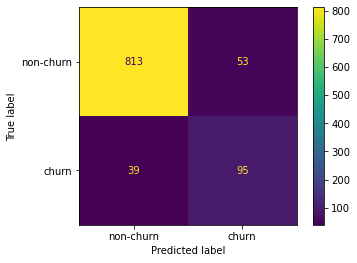

In [41]:
from sklearn.metrics import ConfusionMatrixDisplay

cm = ConfusionMatrixDisplay.from_estimator(
    hyper_SVC, X_test, y_test, values_format="d", display_labels=["non-churn", "churn"]
)

In [42]:
print(
    classification_report(
        y_test, hyper_SVC.predict(X_test), target_names=["non-churn", "churn"]
    )
)

              precision    recall  f1-score   support

   non-churn       0.95      0.94      0.95       866
       churn       0.64      0.71      0.67       134

    accuracy                           0.91      1000
   macro avg       0.80      0.82      0.81      1000
weighted avg       0.91      0.91      0.91      1000



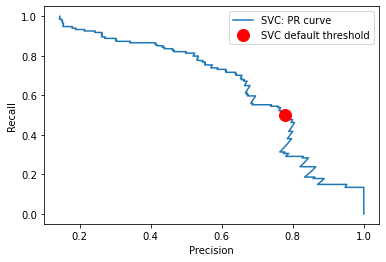

In [43]:
from sklearn.metrics import precision_recall_curve

# The below code is inspired by 573 lecture notes

precision_SVC, recall_SVC, thresholds_SVC = precision_recall_curve(
    y_test, hyper_SVC.predict_proba(X_test)[:,1]
)

close_default_SVC = np.argmin(np.abs(thresholds_SVC - 0.5))

label="SVC: PR curve"
marker_colour="r"
marker_label="SVC default threshold"

plt.plot(precision_SVC, recall_SVC, label=label)
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.plot(
    precision_SVC[close_default_SVC],
    recall_SVC[close_default_SVC],
    "o",
    markersize=12,
    label=marker_label,
    c=marker_colour,
)
plt.legend(loc="best");

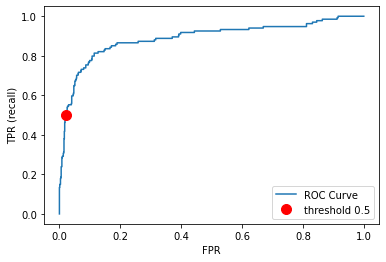

In [44]:
from sklearn.metrics import roc_curve

# The below code has been inspired from 573 notes
fpr, tpr, thresholds = roc_curve(y_test, hyper_SVC.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")

default_threshold = np.argmin(np.abs(thresholds - 0.5))

plt.plot(
    fpr[default_threshold],
    tpr[default_threshold],
    "or",
    markersize=10,
    label="threshold 0.5",
)
plt.legend(loc="best");

In [45]:
from sklearn.metrics import roc_auc_score

roc_lr = roc_auc_score(y_test, hyper_SVC.predict_proba(X_test)[:, 1])
print("AUC for SVC: {:.3f}".format(roc_lr))

AUC for SVC: 0.889


_2. Looking at the classification report, we are interested in the precision, recall and f1-score for the `churn` row as it is our `positive` class. The f1 score on our test set is pretty close to the best f1-score we got in our RandomizedSearchCV and in fact a bit better which shows that our model has generalized well. The recall score of 0.82 seems reasonable considering that we wanted to increase the percentage of capturing the churn class when they are truly churn (in order to improve our service for those customers before losing them)._  

_The high AUC for ROC indicates that the two target classes are well distinguished by our SVC model, and if the decision was to improve recall to above 0.8 we could do so with a small expense on False positive rate._  
_From the PR curve we can see that a higher recall like 0.80 was required, we could achive so by lowering the SVC threshold to a value like 0.25 (I have done these calculations in the background). It is worthy to remind that setting the target class_weight to "balanced" has already created the same effect for us._

<br><br><br><br>

### Exercise 3: Regression metrics <a name="3"></a>
<hr> 


For this exercise, we'll use [California housing dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html) from `sklearn datasets`. The code below loads the dataset.  

In [46]:
from sklearn.datasets import fetch_california_housing

housing_df = fetch_california_housing(as_frame=True).frame
housing_df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


In [47]:
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


### 3.1: Data spitting and exploration 
rubric={accuracy:4}

**Your tasks:**

1. Split the data into train (80%) and test (20%) splits. 
2. Explore the train split. Do you need to apply any transformations on the data? If yes, create a preprocessor with the appropriate transformations. 
3. Separate `X` and `y` in train and test splits. 

In [48]:
X_train, X_test, y_train, y_test = train_test_split(housing_df.drop("MedHouseVal", axis = 1), housing_df["MedHouseVal"], test_size=0.2, random_state=2021)

In [49]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 2782 to 6201
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      16512 non-null  float64
 1   HouseAge    16512 non-null  float64
 2   AveRooms    16512 non-null  float64
 3   AveBedrms   16512 non-null  float64
 4   Population  16512 non-null  float64
 5   AveOccup    16512 non-null  float64
 6   Latitude    16512 non-null  float64
 7   Longitude   16512 non-null  float64
dtypes: float64(8)
memory usage: 1.1 MB


In [50]:
X_train.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000
mean,3.865719,28.599019,5.434371,1.099138,1427.285489,3.064318,35.637277,-119.572842
std,1.893223,12.615809,2.587655,0.496437,1146.895638,10.623352,2.136066,2.002757
min,0.499900,1.000000,0.846154,0.333333,6.000000,0.692308,32.540000,-124.350000
25%,2.568575,18.000000,4.433962,1.006260,788.000000,2.431015,33.930000,-121.790000
50%,3.531750,29.000000,5.226145,1.048830,1165.000000,2.817415,34.260000,-118.500000
75%,4.733050,37.000000,6.050929,1.099417,1727.000000,3.284547,37.720000,-118.010000
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000


In [51]:
all_cols = X_train.columns.tolist()
preprocessor = StandardScaler()

<br><br>

### 3.2 Baseline: DummyRegressor 
rubric={accuracy:2}

**Your tasks:**
1. Carry out cross-validation using `DummyRegressor` with default scoring. 
2. What metric is used for scoring by default? 

In [52]:
dummy_pipe = make_pipeline(preprocessor, DummyRegressor())
dummy_results = pd.DataFrame(cross_validate(dummy_pipe, X_train, y_train, return_train_score=True)).mean()
pd.DataFrame(dummy_results, columns=["Dummy"])

,Dummy
fit_time,0.005846
score_time,0.002701
test_score,-0.000247
train_score,0.000000


_The default scoring method for DummyRegressor is $R^2$._

<br><br>

### 3.3 Different regressors
rubric={accuracy:6,reasoning:2}

In this exercise, we are going to use [`RandomForestRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) model which we haven't looked into yet. At this point you should feel comfortable using models with our usual ML workflow even if you don't know the details. We'll talk about `RandomForestRegressor` later in the course.  

The code below defines a custom scorer called `mape_scorer` and creates dictionaries for different regressors (`models`) and different scoring metrics (`score_types_reg`). 

**Your tasks:**

1. Using the `models` and the evaluation metrics `score_types_reg` in the code below, carry out cross-validation with each model, by passing the evaluation metrics to `scoring` argument of `cross_validate`. Use a pipeline with the model as an estimator if you are applying any transformations. 
2. Show results as a dataframe. 
3. Interpret the results. How do the models compare to the baseline? Which model seems to be performing well with different metrics? 


In [53]:
def mape(true, pred):
    return 100.0 * np.mean(np.abs((pred - true) / true))


# make a scorer function that we can pass into cross-validation
mape_scorer = make_scorer(mape, greater_is_better=False)

models = {
    "Ridge": Ridge(),
    "Random Forest": RandomForestRegressor(),
}

score_types_reg = {
    "neg_mean_squared_error": "neg_mean_squared_error",
    "neg_root_mean_squared_error": "neg_root_mean_squared_error",
    "neg_mean_absolute_error": "neg_mean_absolute_error",
    "r2": "r2",
    "mape_scorer": mape_scorer,
}

In [54]:
result_scores = pd.DataFrame()
for name, model in models.items():
    cv_pipe = make_pipeline(preprocessor, model)
    results = pd.DataFrame(
        cross_validate(cv_pipe, X_train, y_train, scoring=score_types_reg, n_jobs=-1)
    ).mean()
    result_scores = pd.concat(
        [result_scores, pd.DataFrame(results, columns=[name])], axis=1
    )

result_scores

,Ridge,Random Forest
fit_time,0.028174,11.933611
score_time,0.006107,0.123692
test_neg_mean_squared_error,-0.533472,-0.260422
test_neg_root_mean_squared_error,-0.730246,-0.510281
test_neg_mean_absolute_error,-0.531489,-0.333991
test_r2,0.596637,0.803090
test_mape_scorer,-31.716536,-18.813766


_Although it takes much longer to fit the Random Forest model, its score time is reasonable and has better scores across all metrics when compared to Ridge. Both these models perform better than the DummyRegressor._

<br><br>

### (Optional) 3.4 Hyperparameter optimization 
rubric={reasoning:1}

**Your tasks:**
1. Carry out hyperparameter optimization using `RandomizedSearchCV` and `Ridge` with the following `param_dist`. The `alpha` hyperparameter of `Ridge` controls the fundamental tradeoff. Choose the metric of your choice for hyperparameter optimization. 
2. Are you getting better scores compared to the default values?

In [55]:
from scipy.stats import loguniform

param_dist = {"ridge__alpha": loguniform(1e-3, 1e3)}

ridge_pipe = make_pipeline(preprocessor, Ridge(max_iter=200))

ridge_cv = RandomizedSearchCV(ridge_pipe, param_dist, n_iter=20, scoring = "r2")

ridge_cv.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('ridge', Ridge(max_iter=200))]),
                   n_iter=20,
                   param_distributions={'ridge__alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001E1719E3610>},
                   scoring='r2')

In [56]:
ridge_cv.best_params_

{'ridge__alpha': 14.189854603197976}

In [57]:
ridge_cv.best_score_

0.5967148503400501

_The r2 score is almost identical to the r2 score given by default alpha for Ridge._

In [58]:
# Second method
from sklearn.linear_model import RidgeCV

alphas = 10.0 ** np.arange(-3, 3, 1)
ridgecv_pipe = make_pipeline(preprocessor, RidgeCV(alphas=alphas, cv=10))
ridgecv_pipe.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('ridgecv',
                 RidgeCV(alphas=array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                         cv=10))])

In [59]:
ridgecv_pipe.named_steps["ridgecv"].alpha_

100.0

<br><br>

### 3.5 Test results
rubric={reasoning:4}

**Your tasks:**

1. Try the best model on the test set.
2. Briefly comment on the results. (1 to 2 sentences) 

In [60]:
best_pipe = make_pipeline(preprocessor, RandomForestRegressor())

best_pipe.fit(X_train, y_train)
best_pipe.score(X_test, y_test)

0.8123225088965667

In [61]:
# More detailed score analysis
from sklearn.metrics import mean_squared_error, r2_score

print(f"Mean squared error is {mean_squared_error(y_test, best_pipe.predict(X_test))}")
print(f"Root mean squared error is {np.sqrt(mean_squared_error(y_test, best_pipe.predict(X_test)))}")
print(f"R2 score is {r2_score(y_test, best_pipe.predict(X_test))}")
print(f"MAPE score is {mape(y_test, best_pipe.predict(X_test))}")

Mean squared error is 0.25650438486539
Root mean squared error is 0.5064626194156782
R2 score is 0.8123225088965667
MAPE score is 18.494977834588074


_According to the above scores which are very close to the cross_validation scores calculated in 3.3, we can say that this model will generalize well on the deployment data. The r2 score seems reasonable and the MAPE score of 18.41% average difference from target sounds good._

<br><br>

### 3.6 Model interpretation  
rubric={reasoning:4}

Ridge is a linear model and it learns coefficients associated with each feature during `fit()`. 

**Your tasks:**

1. Visualize coefficients learned by the `Ridge` model above as a pandas dataframe with two columns: features and coefficients. If you attempted 3.4, use the `Ridge` model with best hyperparameters. Otherwise use the `Ridge` model with default hyperparameters. 
2. According to the model, increasing which feature values would result in higher housing price? 

In [62]:
best_ridge = make_pipeline(preprocessor, Ridge(alpha = ridge_cv.best_params_['ridge__alpha']))
best_ridge.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('ridge', Ridge(alpha=14.189854603197976))])

In [63]:
features = X_train.columns.tolist()
coefficients = best_ridge.named_steps['ridge'].coef_.tolist()

pd.DataFrame({"features": features, "coefficients": coefficients}).sort_values("coefficients", ascending=False)

,features,coefficients
0,MedInc,0.825746
3,AveBedrms,0.324817
1,HouseAge,0.116064
4,Population,-0.002721
5,AveOccup,-0.041229
2,AveRooms,-0.278804
7,Longitude,-0.863358
6,Latitude,-0.891866


_2. From the sorted table above we can see that Median Income and Average number of bedrooms have the highest coefficients, and therefore, more likely to contribute the most to the housing price if increase._

<br><br><br><br>

**PLEASE READ BEFORE YOU SUBMIT:** 

When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order or not starting from "1" will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Push all your work to your GitHub lab repository. 
4. Upload the assignment using Gradescope's drag and drop tool. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission. 
5. Make sure that the plots and output are rendered properly in your submitted file. 